# CNN Implementation for the Simpsons Characters Recognition

In [20]:
# paste below in your terminal after activating your conda environment
# git clone https://github.com/Yichen-Wang-2003/M156_Group1_Final_project

In [21]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import os

In [22]:
print(os.getcwd())

/Users/ningsam/Desktop/Winter_2024/M156_Group1_Final_project/archive/simpsons_dataset


In [23]:
os.chdir('/Users/ningsam/Desktop/Winter_2024/M156_Group1_Final_project/archive/simpsons_dataset')

In [24]:
print(os.getcwd())

/Users/ningsam/Desktop/Winter_2024/M156_Group1_Final_project/archive/simpsons_dataset


## 1. Data Processing and Dataloader

In [25]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

data = datasets.ImageFolder(root='/Users/ningsam/Desktop/Winter_2024/M156_Group1_Final_project/archive/simpsons_dataset', transform=transform)

dataloader = DataLoader(data, batch_size=64, shuffle=True, num_workers=2)

def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    
    return mean, std

mean, std = get_mean_std(dataloader)

print(f'mean: {mean}')
print(f'std: {std}')

mean: tensor([0.4623, 0.4074, 0.3522])
std: tensor([0.2443, 0.2214, 0.2534])


In [26]:
print(len(data.classes))

42


In [27]:
# data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(),
                         std=std.tolist())
])

data = datasets.ImageFolder(root='/Users/ningsam/Desktop/Winter_2024/M156_Group1_Final_project/archive/simpsons_dataset', transform=transform)

# split the dataset into training and validation
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

# create data loaders for training, validation, and testing
train = DataLoader(train_data, batch_size=64, shuffle=True)
val = DataLoader(val_data, batch_size=64, shuffle=False)
test = DataLoader(test_data, batch_size=64, shuffle=True)

In [28]:
print(len(data.classes))

42


In [29]:
print(f'found {len(train_data)} images belonging to {len(data.classes)} classes in the training set.')
print(f'found {len(val_data)} images belonging to {len(data.classes)} classes in the validation set.')
print(f'found {len(test_data)} images belonging to {len(data.classes)} classes in the validation set.')

found 16746 images belonging to 42 classes in the training set.
found 2093 images belonging to 42 classes in the validation set.
found 2094 images belonging to 42 classes in the validation set.


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
import time


In [31]:
torch.manual_seed(42)  # for reproducibility

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


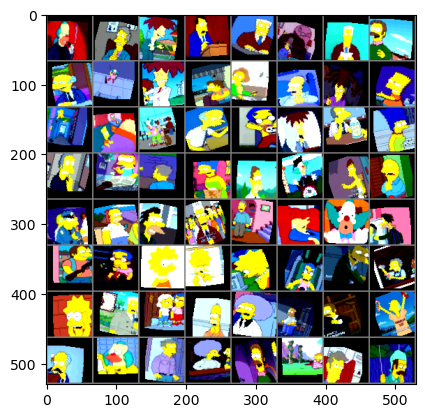

Labels: tensor([17, 32, 37, 24, 16, 25, 16, 28,  6, 17, 37, 29, 11, 15, 37,  4,  6,  4,
        17,  6, 25, 37, 27, 22, 27, 20,  7, 22,  0, 17,  8, 35,  7, 15, 18, 16,
        32,  6, 17, 18, 29, 25, 20, 20, 20, 25, 27, 27, 20, 16, 25, 15, 31, 15,
        28,  6,  6, 17, 32, 31, 28, 20, 32, 28])


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# Assuming 'train' is your DataLoader for the training set
dataiter = iter(train)  # Create an iterator over the DataLoader
images, labels = next(dataiter)   # Fetch the first batch of images and labels

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', labels)


In [33]:
dataloaders = {
    'train': train,
    'val': val
}
dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data)
}


## 2. Convolutional Neural Network and Resnet Block for Simpson Character Recognition

In [34]:
class ResnetBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResnetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.downsample = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):

        i = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += i
        out = self.relu1(out)
        return out

In [35]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)  # Added BatchNorm
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Conv
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Added BatchNorm
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Conv
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Two resnet layers
        self.ResnetBlock1 = ResnetBlock(128, 128)
        self.ResnetBlock2 = ResnetBlock(128, 128)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(8192, 1024) 
        self.relu4 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(512, num_figure)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.maxpool1(x)
    
        x = self.relu2(self.conv2(x))
        x = self.maxpool2(x)
        
        x = self.relu3(self.conv3(x))
        x = self.maxpool3(x)

        x = self.ResnetBlock1(x)
        x = self.ResnetBlock2(x)
        
        x = self.dropout(x)

        x = x.view(x.size(0), -1)

        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)
        return x

## 3. Training phase and validation

In [36]:
# number of Simpson characters
num_figure = 42
epoch_limit = 100
model = ConvNet()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Set criterion to be CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Using L2 regularization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Setup scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Setup early stopping
stop_training = False
count_early_stop = 0
best_loss = None


# Set some thing to store and keep track of the best model
val_loss = []
val_acc = []
train_loss = []
train_acc = []
epoch_update = 0
# keep training until early stop met or reach epoch limit
while not stop_training and epoch_update < epoch_limit:
  
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    running_loss = 0.0
    running_corrects = 0
    # iterate over data
    for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        if phase == 'train':
          loss.backward()
          optimizer.step()

      # update loss
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    if(phase == 'train'):
      train_loss.append(epoch_loss)
      train_acc.append(epoch_acc)
    else:
      val_loss.append(epoch_loss)
      val_acc.append(epoch_acc)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # check early stop conditions for every epoch
    if phase == 'val':
      if best_loss == None or epoch_loss < best_loss:
        best_loss = epoch_loss
        count_early_stop = 0
        torch.save(model.state_dict(), 'best_model.pt')
      else:
        count_early_stop += 1
        if count_early_stop > 3:  # stop if validation loss does not improve for 3 epochs
          stop_training = True
      epoch_update += 1
      
  scheduler.step()

train Loss: 2.4565 Acc: 0.3194
val Loss: 2.1062 Acc: 0.4190
train Loss: 1.6013 Acc: 0.5564
val Loss: 1.5764 Acc: 0.5619
train Loss: 1.2516 Acc: 0.6450
val Loss: 1.2457 Acc: 0.6445
train Loss: 1.0606 Acc: 0.7003
val Loss: 0.9945 Acc: 0.7229
train Loss: 0.9189 Acc: 0.7435
val Loss: 1.0180 Acc: 0.7176
train Loss: 0.8156 Acc: 0.7682
val Loss: 0.8868 Acc: 0.7516
train Loss: 0.7390 Acc: 0.7863
val Loss: 0.9148 Acc: 0.7372
train Loss: 0.6027 Acc: 0.8271
val Loss: 0.6424 Acc: 0.8170
train Loss: 0.5597 Acc: 0.8414
val Loss: 0.6625 Acc: 0.8098
train Loss: 0.5455 Acc: 0.8422
val Loss: 0.6383 Acc: 0.8223
train Loss: 0.5312 Acc: 0.8492
val Loss: 0.6069 Acc: 0.8395
train Loss: 0.5183 Acc: 0.8503
val Loss: 0.6059 Acc: 0.8256
train Loss: 0.5107 Acc: 0.8533
val Loss: 0.6213 Acc: 0.8266
train Loss: 0.4975 Acc: 0.8589
val Loss: 0.6132 Acc: 0.8376
train Loss: 0.4864 Acc: 0.8630
val Loss: 0.6125 Acc: 0.8313
train Loss: 0.4790 Acc: 0.8624
val Loss: 0.5786 Acc: 0.8447
train Loss: 0.4754 Acc: 0.8603
val Loss:

In [38]:
print(epoch_update)

20


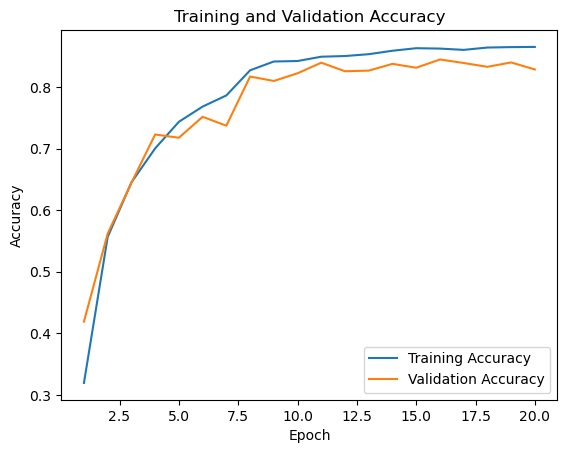

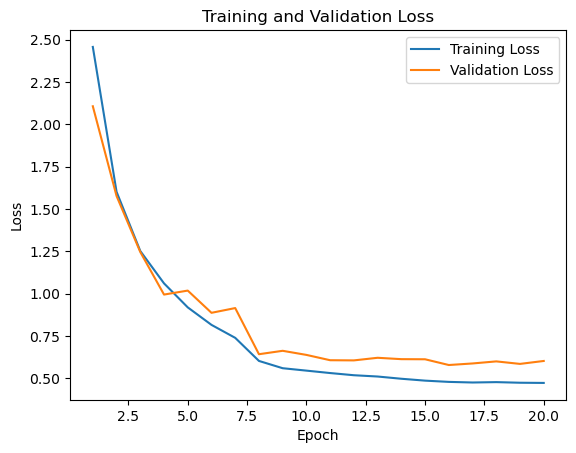

In [40]:
# # Visualize the validaton accuracy and training accuracy
epochs = list(range(1, 21))
plt.plot(epochs, train_acc, label='Training Accuracy', color='red')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Draw plot for training and validation loss
plt.plot(epochs, train_loss, label='Training Loss', color='red')
plt.plot(epochs, val_loss, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## 4. Test set evaluation

In [41]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0

# Prestored for visualization
images_num = 10
s_images = []
s_preds = []
s_truth = []

with torch.no_grad():  # Do not calculate gradient 
    for inputs, labels in test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()  # Sum up batch loss
        pred = outputs.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()

        # Select some images to visualize
        if len(s_images) < images_num:
            s_images.extend(inputs.cpu().data[:images_num-len(s_images)])
            s_preds.extend(pred.view(-1).cpu().data[:images_num-len(s_preds)])
            s_truth.extend(labels.cpu().data[:images_num-len(s_truth)])

test_loss /= len(test.dataset)
test_accuracy = 100. * correct / len(test.dataset)
print(f'Testset result: Average loss: {test_loss:.5f}, Accuracy: {correct}/{len(test.dataset)} ({test_accuracy:.2f}%)')


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pt'